In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import math
import unicodedata, re
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet


%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
acquired_dict = {
    'tr':'tr',
    'fa':'fa',
    'dr':'dr',
    "Traded": "tr",
    "Free Agency": "fa",
    "Amateur Draft": "dr",
    "Amateur Free Agent": "fa",
    "Waivers": "tr",
    "Purchased":"tr",
    "Rule 5 Draft": "dr",
    "Expansion Draft": "dr",
    "Conditional Deal": "tr",
    "Amateur Draft--no sign": "dr",
    "MinorLg Draft": "dr",
    "Rune 5 returned": "tr"
}

def inflation_calc(row):
    inf_dict = {
     2017: 1.0,
     2016: 1.021299290023666,
     2015: 1.0341874211554445,
     2014: 1.0354149770208165,
     2013: 1.0522113523096537,
     2012: 1.0676237183898534,
     2011: 1.089717656786951,
     2010: 1.1241149062626115,
     2009: 1.1425534989302544,
     2008: 1.1384885486964882,
     2007: 1.1822013870802828,
     2006: 1.215873015873016,
     2005: 1.2550947260624679,
     2004: 1.297617787188989,
     2003: 1.3324635790389214,
     2002: 1.3626862352679565,
     2001: 1.3843112893206078,
     2000: 1.4234610917537749
    }
    return int(row['salary']*inf_dict[row['year']])

def fixtm(t):
    if t == '2TM' or t == '3TM' or t == '4TM':
        return 'multiple'
    elif t == 'TBD':
        return 'TBR'
    elif t == 'MON':
        return "WSN"
    elif t == 'ANA':
        return 'LAA'
    elif t == 'FLA':
        return 'MIA'
    else: return t
    
    
def fix_name(n):
    n = (' ').join(n.split('\xa0'))
    return re.sub(r'[^\w\s]','',n)

In [37]:
def elastic(cutoff = 1):
    train_X, train_y, test_X, test_y = load_and_split_data(cutoff)
    
    regr = ElasticNetCV(alphas=[.2,.3,.5,.9,.99,1],cv=10,tol=0.01)
    
    regr.fit(train_X,train_y)
    
    preds = regr.predict(test_X)
    
    error = np.sqrt(MSE(test_y,preds))
    
    return round(10**error,2), regr.get_params()

In [7]:
def train_and_test(cutoff = 1000000):
    train_X,train_y,test_X,test_y = load_and_split_data(cutoff)

    
    lr = LinearRegression()

    lr.fit(train_X, train_y)

    preds = lr.predict(test_X)

    error = np.sqrt(MSE(test_y,preds))
    
    return round(10**error,2)

In [8]:
def cutoff_df(df,cutoff):
    log_10_cut = math.log10(cutoff)
    df = df[df['log10_adj'] >= log_10_cut]
    return df

In [16]:
def test_elastic_cutoffs():
    test_cutoffs = [(i+1)*100000 for i in range(20)]
    error_list = []
    for i in test_cutoffs:
        error = elastic(i)
        error_list.append(error)
    return test_cutoffs,error_list    

In [9]:
def test_cutoffs():
    test_cutoffs = [(i+1)*100000 for i in range(20)]
    error_list = []
    for i in test_cutoffs:
        error = train_and_test(i)
        error_list.append(error)
    return test_cutoffs,error_list

In [10]:
def load_data():
    train = pd.read_pickle('batting_00_16.pkl')
    test = pd.read_pickle('batting_17.pkl')
    return train,test

In [11]:
def engineer_features(df):
    df = df[df.pa>200]

    df = df.reset_index()
    
    df['name'] = df['name'].apply(fix_name)
    #adjust team names
    df['tm'] = df['tm'].apply(fixtm)
    #drop position summary (too many classes), log_sal (unscaled by inflation), rk (same as index)
    df.drop(['pos\xa0summary','log_sal','rk','index'],axis=1,inplace=True)
    #map values in acquired to 3 classes
    df['acquired'] = df['acquired'].map(acquired_dict)
    
    #adjust salary for inflation and take the log-10 for target column
    df['adj_salary'] = df.apply(inflation_calc,axis=1)
    df['log10_adj'] = np.log10(df['adj_salary'])
    
    #get dummy variables for team, hand, and acquired columns
    df = pd.get_dummies(df,columns = ['acquired','bat_hand','tm']).drop(['tm_multiple','bat_hand_rhb','acquired_tr'],axis=1)
    #filter datasets for only batters with more than 200 plate appearances in season

    return df

def scaleColumns(df, cols_to_scale):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df    

def rescale_numeric(df):
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    cols = [ 'g',
         'pa',
         'rbat',
         'rbaser',
         'rdp',
         'rfield',
         'rpos',
         'raa',
         'waa',
         'rrep',
         'rar',
         'war',
         'waawl%',
         '162wl%',
         'owar',
         'dwar',
         'orar',
         'year','ab','r','h','2b','3b','hr','rbi','sb','cs','bb','so','ibb','hbp','sh','sf','gidp']
    df = scaleColumns(df,cols)

    return df

In [12]:
def combine_with_lehman_data(df):
    players = pd.read_csv('baseballdatabank-master/core/People.csv')
    #players = players.set_index('playerID')

    drop_cols = ['deathYear','deathMonth','deathDay','deathCountry','deathState','deathCity',
                'birthYear','birthMonth','birthDay','birthCountry','birthState','birthCity',
                'nameGiven','weight','height','bats','throws','finalGame','retroID','bbrefID']
    players = players.drop(drop_cols,axis=1)
    players['fullname'] = players['nameFirst'] + ' ' + players['nameLast']
    players = players.dropna()

    players['fullname'] = players['fullname'].apply(lambda x: ''.join(re.sub(r'[^\w\s]','',x).split(' ')).lower())
    
    batting = pd.read_csv('baseballdatabank-master/core/Batting.csv')
    bats = batting[batting['yearID'] >= 2000]
    
    bat_join = bats.merge(players,how='left',on='playerID')

    keep_cols = ['yearID',
     'G',
     'AB',
     'R',
     'H',
     '2B',
     '3B',
     'HR',
     'RBI',
     'SB',
     'CS',
     'BB',
     'SO',
     'IBB',
     'HBP',
     'SH',
     'SF',
     'GIDP',
     'debut',
     'fullname']

    bat_join = bat_join[keep_cols]

    bat_join.columns = [x.lower() for x in bat_join.columns]

    bat_join = bat_join.groupby(['fullname','yearid','debut'],axis=0)['g','ab','r','h','2b','3b','hr','rbi','sb','cs','bb','so','ibb','hbp','sh','sf','gidp'].sum().reset_index()
    bat_join['str_g'] = bat_join['g'].apply(str)
    bat_join['str_year'] = bat_join['yearid'].apply(str)
    bat_join['name_g_y'] = bat_join['fullname'] + ' ' + bat_join['str_g'] + ' ' + bat_join['str_year']
    
    df['str_g'] = df['g'].apply(str)
    df['str_year'] = df['year'].apply(str)
    df['name'] = df['name'].apply(fix_aoki_and_castell)
    df['name_g_y'] = df['name'].apply(lambda x: ''.join(x.split(' ')).lower()) + ' ' + df['str_g'] + ' ' + df['str_year']
    
    df = df.merge(bat_join,how='left',on='name_g_y')
    
    df = df.dropna()

    df['debut_year'] = df['debut'].apply(lambda x: int(x.split('-')[0]))

    df['years_in_mlb'] = df['year'] - df['debut_year']
    
    df['g'] = df['g_x']

    df = df.drop(['g_x','g_y','str_g_x','str_g_y','str_year_x','str_year_y','debut','debut_year','yearid','name_g_y','fullname'],axis=1)
    return df




In [13]:
def fix_aoki_and_castell(name):
    if name == 'Norichika Aoki':
        return 'Nori Aoki'
    elif name == 'Nicholas Castellanos':
        return 'Nick Castellanos'
    else: return name
    
def fix_name(n):
    n1 = (' ').join(n.split('\xa0'))
    n2 = re.sub(r'[^\w\s]','',n1)
    return n2

In [135]:
def load_and_split_data(cutoff = 1):
    #Load dataframes from pickle
    train,test = load_data()
    
    #Scale inflation and engineer categorical features
    train = engineer_features(train)
    test = engineer_features(test)
    
    #Combine calculated statistics scraped from baseball-reference with raw stats from Lehman database
    train = combine_with_lehman_data(train)
    test = combine_with_lehman_data(test)    
    
    #Rescale numeric features to be (0,1)
    train = rescale_numeric(train)
    test = rescale_numeric(test)
    
    #Cut dataframe by minimum salary
    train = cutoff_df(train,cutoff)
    test = cutoff_df(test,cutoff)
    
    #Split into features and response matrices
    train_y = train['log10_adj']
    test_y = test['log10_adj']
    train_X = train.drop(['name','age','log10_adj','salary','adj_salary'],axis=1)
    test_X = test.drop(['name','age','log10_adj','salary','adj_salary'],axis=1)
    
    return train_X, train_y, test_X, test_y

In [74]:
a,b,c,d = load_and_split_data(1)

In [76]:
cut,err = test_cutoffs()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


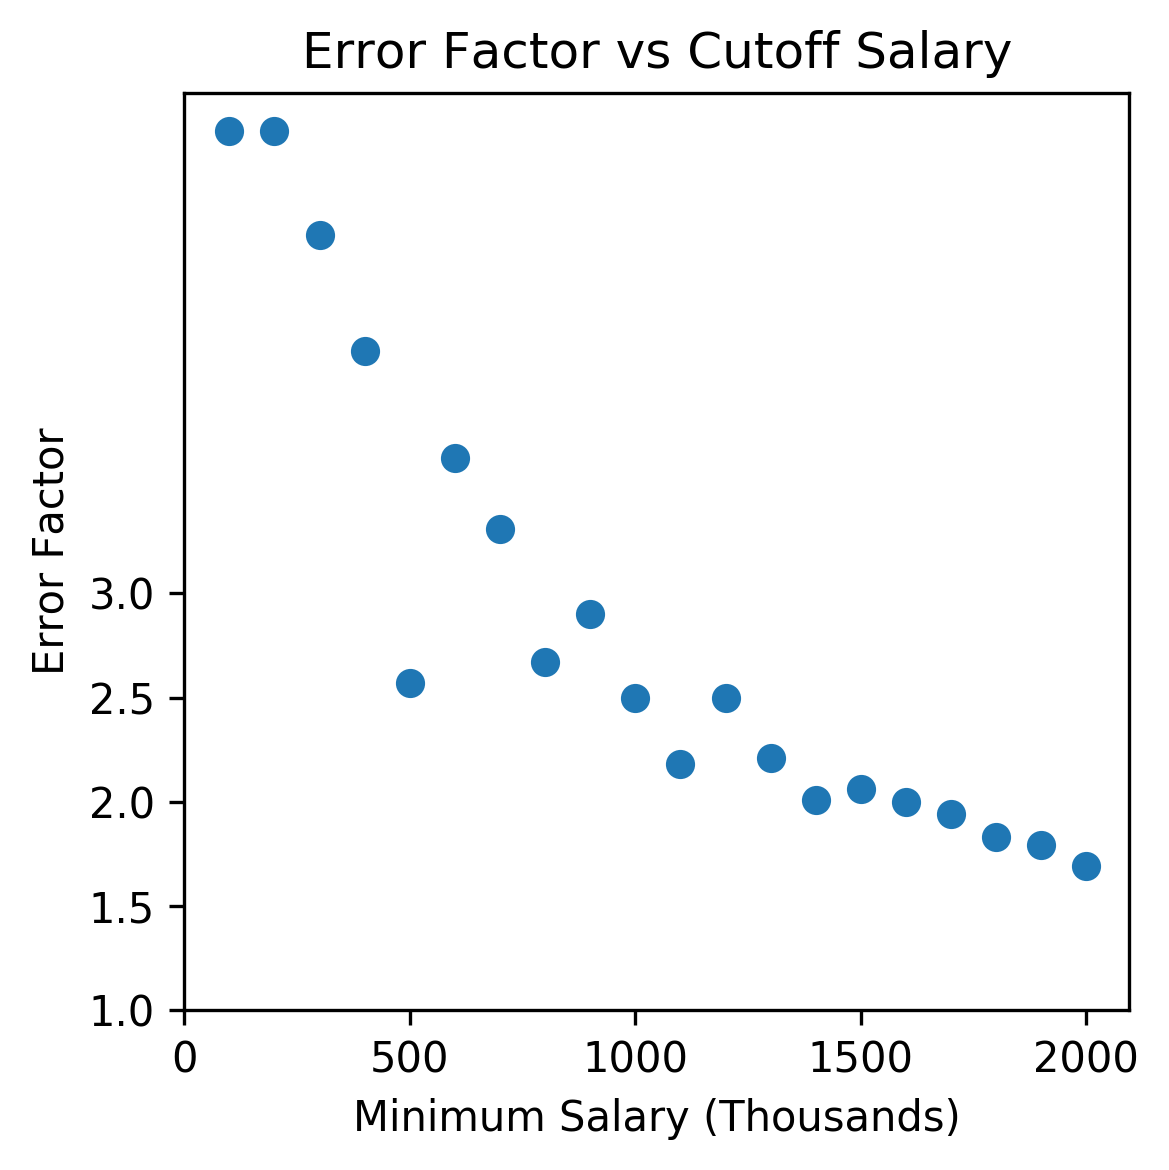

In [77]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter([i/1000 for i in cut],err)
ax.set_title("Error Factor vs Cutoff Salary")
ax.set_ylabel("Error Factor")
ax.set_xlabel("Minimum Salary (Thousands)")
ax.set_yticks([1,1.5,2,2.5,3]);
ax.set_xticks([0,500,1000,1500,2000]);
plt.tight_layout()
plt.savefig('cutofferr.png')

In [129]:
min_sal_year = a.join(b).groupby(['year'])['log10_adj'].min()

In [133]:
min_sal_df = pd.DataFrame(min_sal_year)

In [135]:
min_sal_df['salary'] = 10**min_sal_df['log10_adj']

In [138]:
min_sal_df.reset_index(inplace=True)

In [145]:
min_sal_df['fix_year'] = (min_sal_df['year']*16 +2000).astype(int)

In [146]:
min_sal_df

,year,log10_adj,salary,fix_year
0,0.0000,5.454375,284692.0,2000
1,0.0625,5.442263,276862.0,2001
2,0.1250,5.435425,272537.0,2002
3,0.1875,5.343647,220621.0,2003
4,0.2500,5.590268,389285.0,2004
5,0.3125,5.598363,396609.0,2005
6,0.3750,5.562008,364761.0,2006
7,0.4375,5.652475,449236.0,2007
8,0.5000,5.647393,444010.0,2008
9,0.5625,5.659936,457021.0,2009


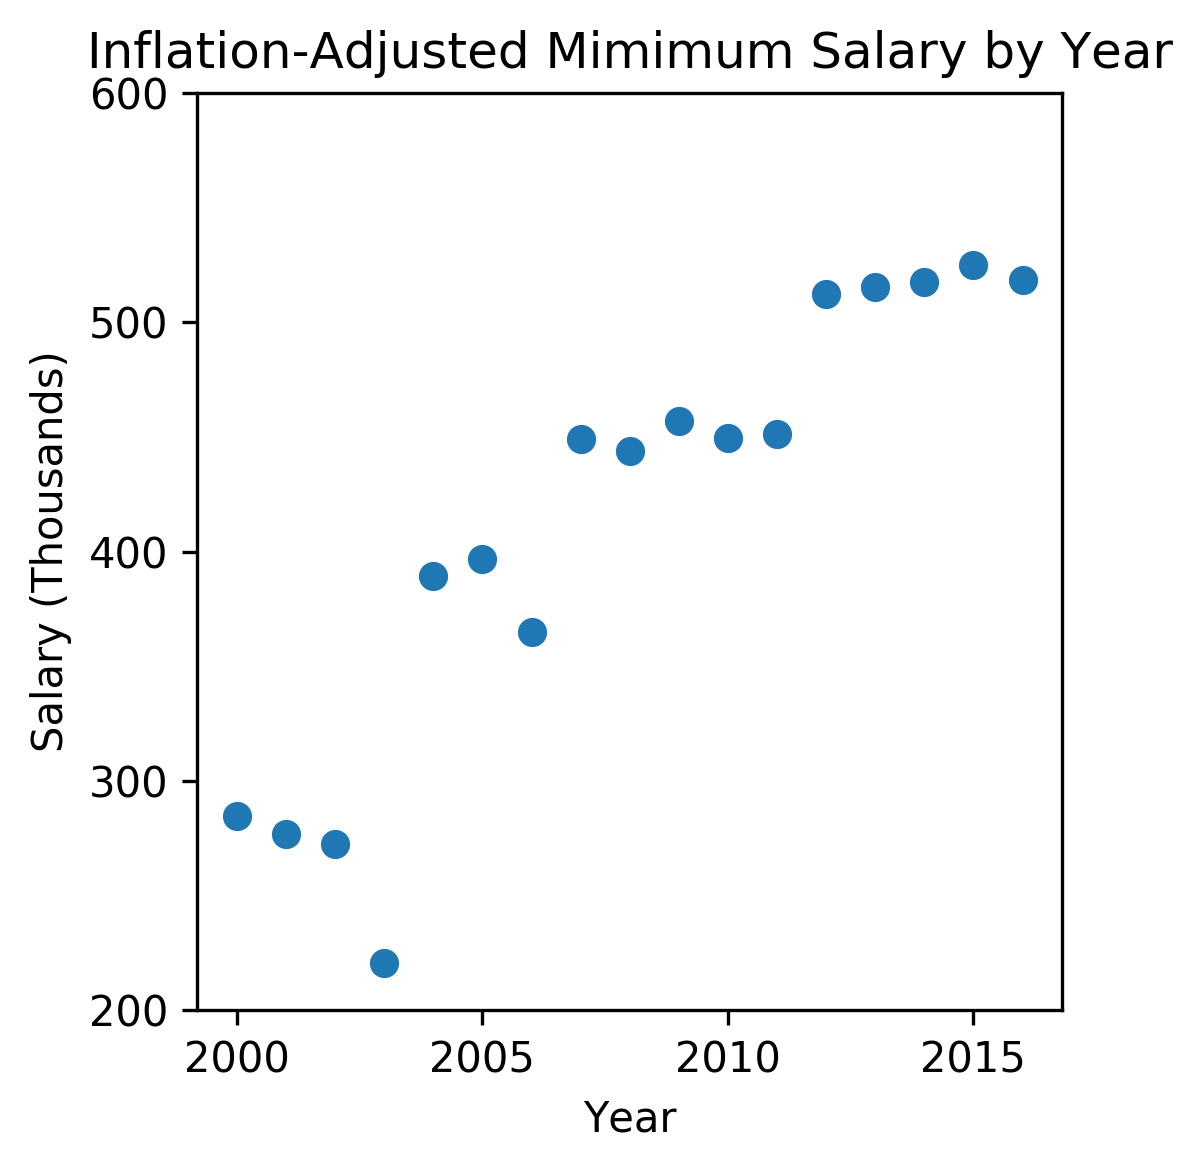

In [192]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(min_sal_df.fix_year,min_sal_df.salary/1000)
ax.set_title('Inflation-Adjusted Mimimum Salary by Year')
ax.set_yticks([200,300,400,500,600])
ax.set_ylabel("Salary (Thousands)")
ax.set_xlabel("Year");
plt.tight_layout()
plt.savefig('adjmin.png')

In [163]:
full_train = a.join(b)

full_train['salary'] = 10**full_train['log10_adj']

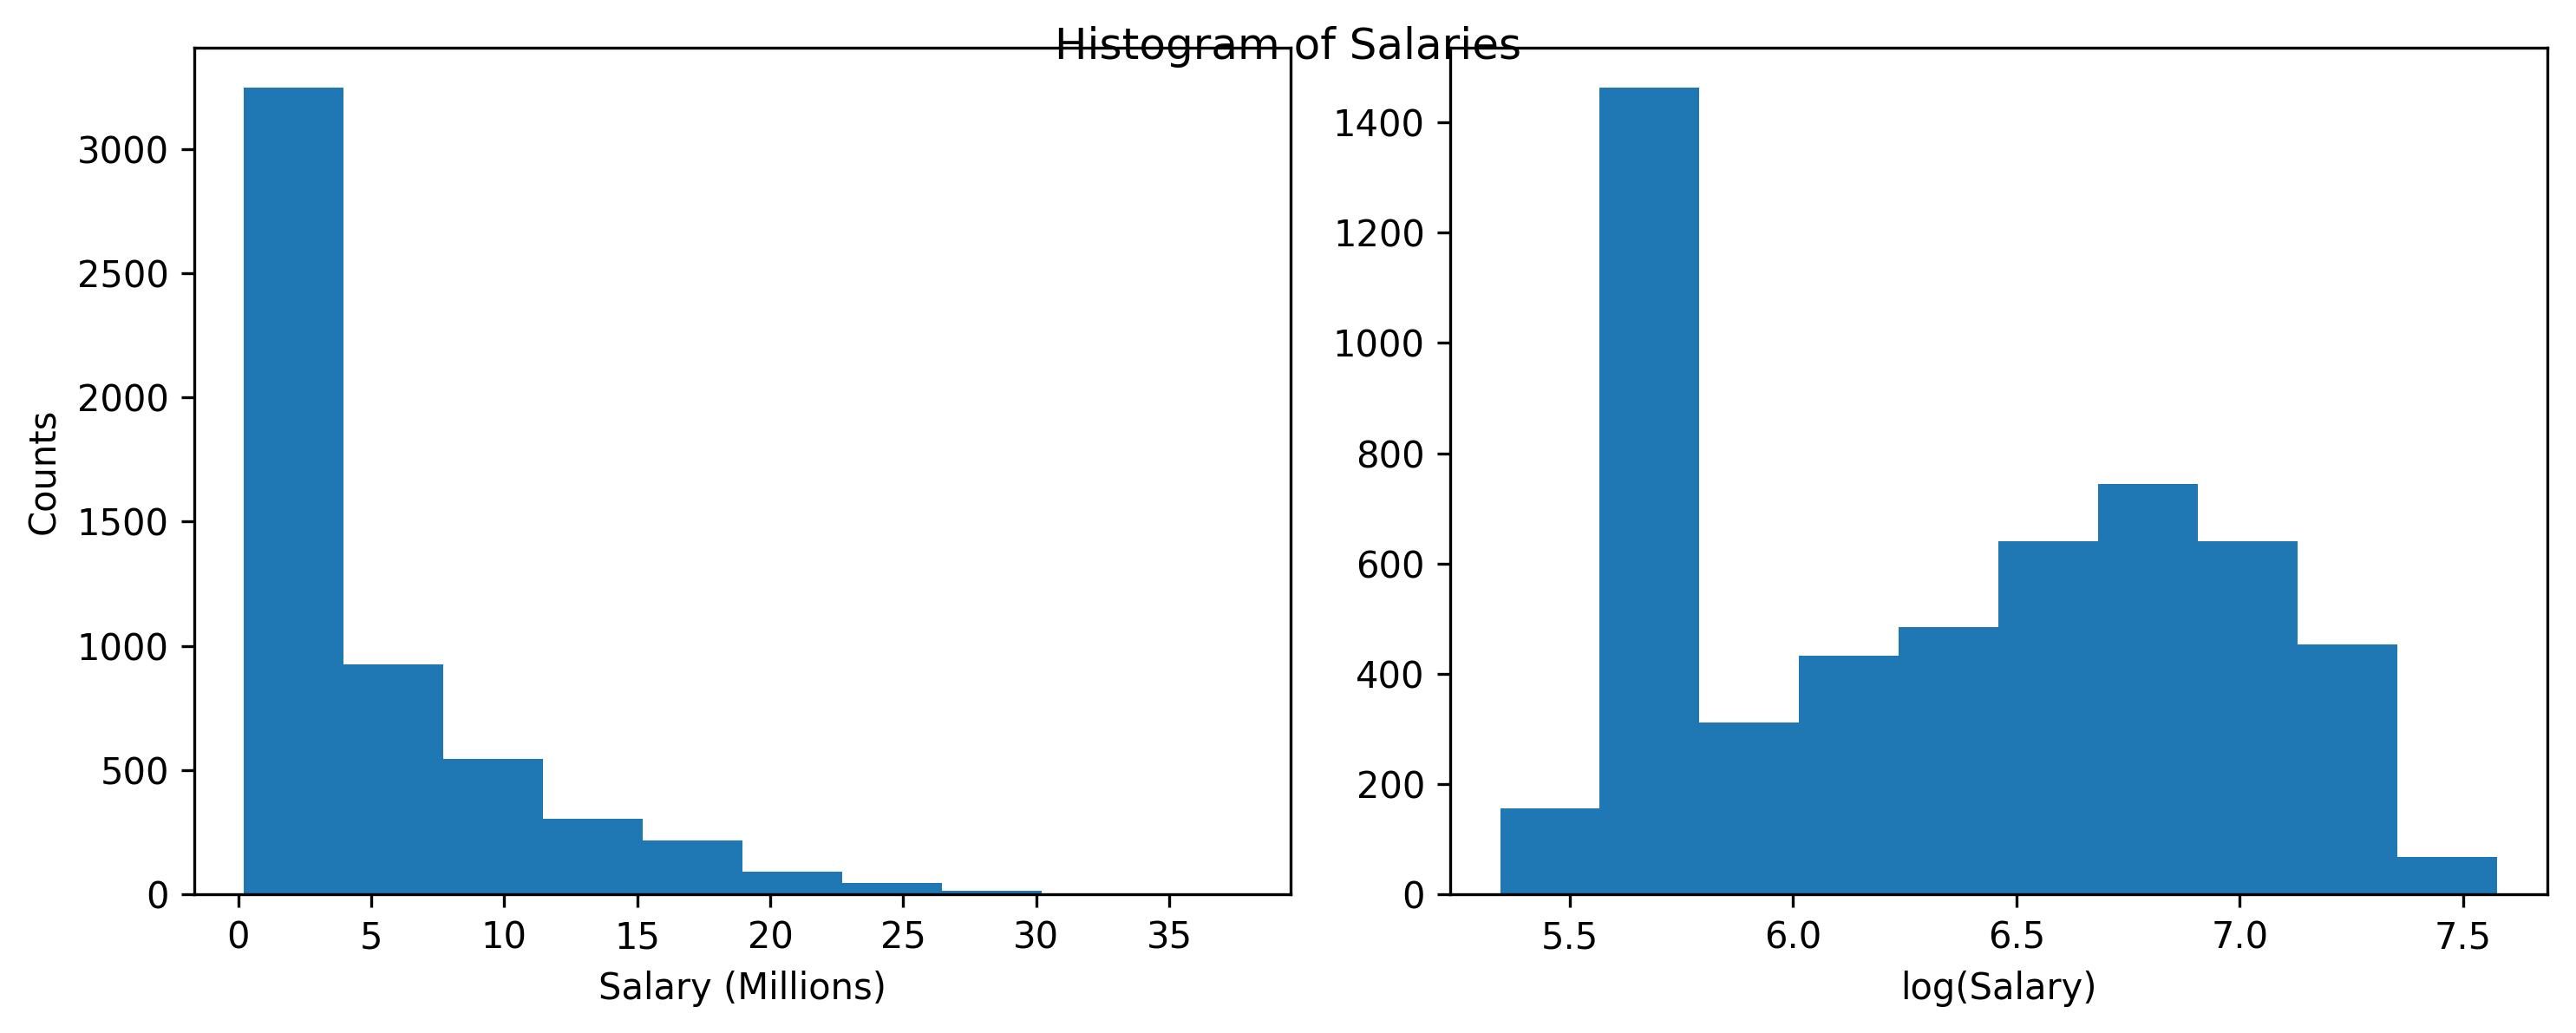

In [191]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.hist(full_train['salary']/1000000)
ax2.hist(full_train['log10_adj'])
fig.suptitle("Histogram of Salaries")
ax1.set_ylabel('Counts')
ax1.set_xlabel("Salary (Millions)")
ax2.set_xlabel('log(Salary)');
plt.tight_layout()
plt.savefig('salaryhist.png')


In [189]:
a.shape

(5395, 54)

In [190]:
c.shape

(315, 54)

In [10]:
tr,te = load_data()

In [11]:
tr.shape

(13464, 27)

In [19]:
cut, err = test_elastic_cutoffs()

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

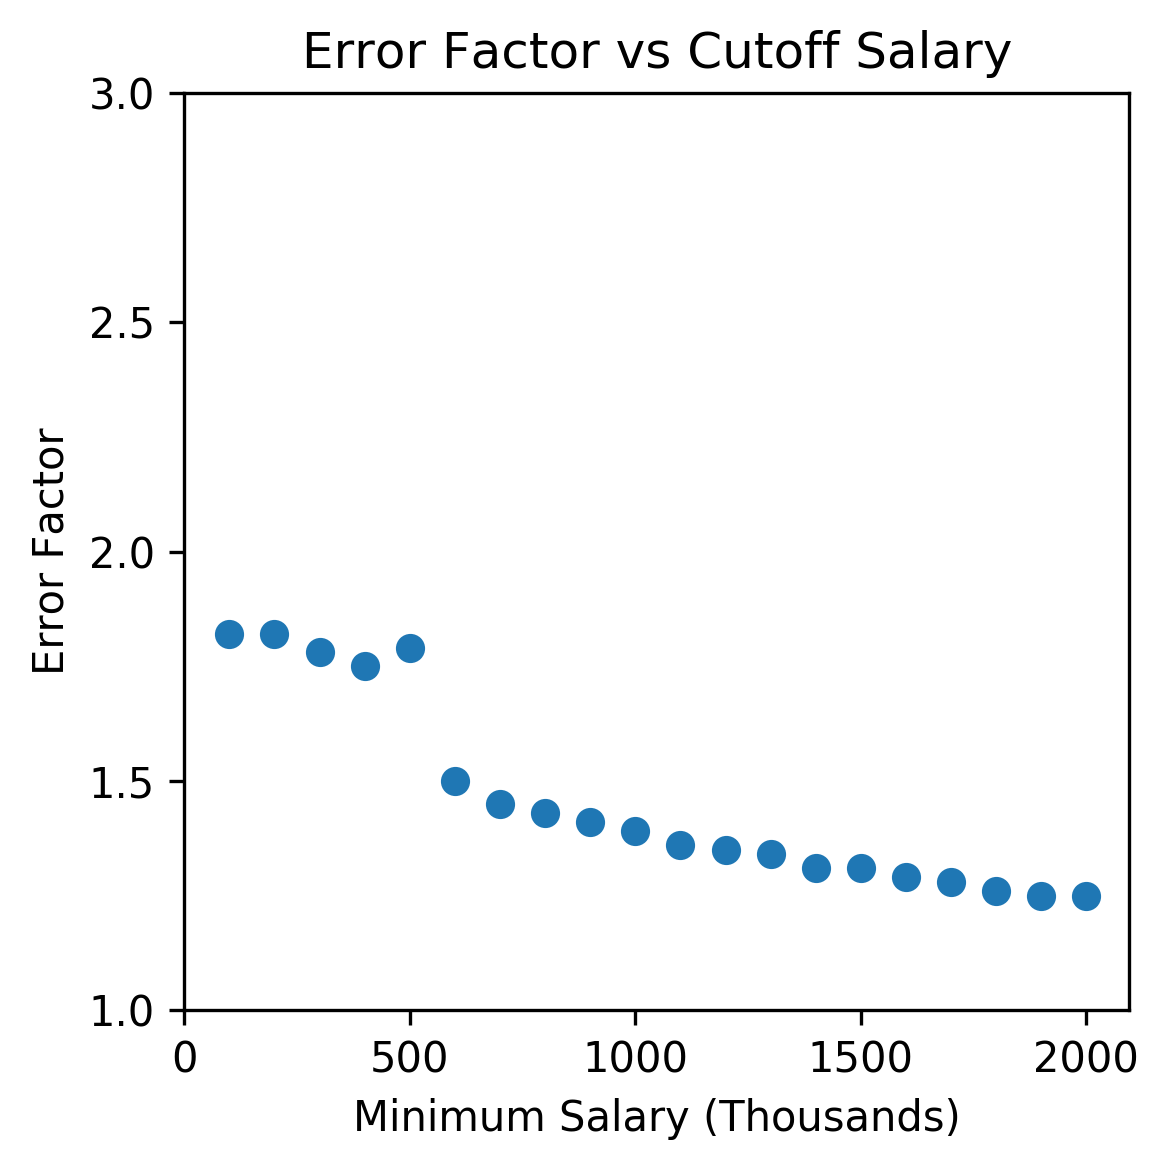

In [22]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter([i/1000 for i in cut],err)
ax.set_title("Error Factor vs Cutoff Salary")
ax.set_ylabel("Error Factor")
ax.set_xlabel("Minimum Salary (Thousands)")
ax.set_yticks([1,1.5,2,2.5,3]);
ax.set_xticks([0,500,1000,1500,2000]);
plt.tight_layout()
#plt.savefig('cutofferr.png')

In [38]:
err, param = elastic(500000)

In [42]:
train_X, train_y, test_X, test_y = load_and_split_data(500000)

regr = ElasticNetCV(alphas=[.2,.3,.5,.9,.99,1],cv=10,tol=0.01)

regr.fit(train_X,train_y)

preds = regr.predict(test_X)

error = np.sqrt(MSE(test_y,preds))

print(np.round(10**error,2),regr.score(train_X,train_y))

1.83 0.7819882032813383


In [50]:
import time

In [149]:
def train_EN_model(train_x, train_y, predict_x):
    #print_title("ElasticNet")
    #train_x, predict_x = standarize_feature(_train_x, _predict_x)

    #l1_ratios = [1e-4, 1e-3, 1e-2, 1e-1]
    #l1_ratios = [1e-5, 1e-4, 1e-3]
    l1_ratios = [.01,.1,.5, 0.99]
    #l1_ratios = [0.5]
    min_mse = 1
    for r in l1_ratios:
        t1 = time.time()
        reg_en = ElasticNetCV(
            l1_ratio=r, cv=10, n_jobs=-1, verbose=1, precompute=True)
        reg_en.fit(train_x, train_y)
        n_nonzeros = (reg_en.coef_ != 0).sum()
        _mse = np.mean(reg_en.mse_path_, axis=1)[
            np.where(reg_en.alphas_ == reg_en.alpha_)[0][0]]
        if _mse < min_mse:
            min_mse = _mse
            best_l1_ratio = r
            best_alpha = reg_en.alpha_
        t2 = time.time()
        print("ratio(%e) -- n: %d -- alpha: %f -- mse: %f -- "
              "time: %.2f sec" %
              (r, n_nonzeros, reg_en.alpha_, _mse, t2 - t1))

    print("Best l1_ratio and alpha: %f, %f" % (best_l1_ratio, best_alpha))
    # predict_model
    reg = ElasticNet(l1_ratio=best_l1_ratio, alpha=best_alpha)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(predict_x)
    train_y_pred = reg.predict(train_x)
    return {"y": predict_y, "train_y": train_y_pred, "coef": reg.coef_}

In [76]:
results = train_EN_model(train_X,train_y,test_X)

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
....................................................................................................................

ratio(9.000000e-01) -- n: 2 -- alpha: 2771.374890 -- mse: 0.057815 -- time: 0.25 sec


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................................

ratio(9.200000e-01) -- n: 2 -- alpha: 2711.127610 -- mse: 0.057815 -- time: 0.26 sec


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................

ratio(9.500000e-01) -- n: 2 -- alpha: 2625.513053 -- mse: 0.057815 -- time: 0.26 sec


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................................................

ratio(9.700000e-01) -- n: 2 -- alpha: 2571.378764 -- mse: 0.057815 -- time: 0.26 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..................................................................................................................

ratio(9.900000e-01) -- n: 2 -- alpha: 2519.431718 -- mse: 0.057815 -- time: 0.35 sec
Best l1_ratio and alpha: 0.990000, 2519.431718


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [77]:
error = MSE(test_y,results['y'])

In [78]:
10**error

1.1853549879135483

In [74]:
for i in range(35,40):
    print (int(10**test_y[i]),int(10**results['y'][i]))

13000000 10345482
1050000 1412661
535000 1296498
8250000 4688527
15000000 14436854


In [126]:
def cutoffs_ENCV():
    test_cutoffs = [(i+1)*100000 for i in range(20)]
    error_list = []
    for i in test_cutoffs:
        train_X, train_y, test_X, test_y = load_and_split_data(i)
        results = train_EN_model(train_X,train_y,test_X)
        error = MSE(test_y,results['y'])**.5
        error_list.append(10**error)

    return test_cutoffs,error_list  
    

In [150]:
cut,err = cutoffs_ENCV()

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(1.000000e-02) -- n: 51 -- alpha: 0.147653 -- mse: 0.156676 -- time: 0.22 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..................................................................................................................

ratio(1.000000e-01) -- n: 43 -- alpha: 0.014765 -- mse: 0.143595 -- time: 0.34 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.................................................................................................................

ratio(5.000000e-01) -- n: 34 -- alpha: 0.002953 -- mse: 0.137308 -- time: 0.24 sec


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
...............................................................................................................

ratio(9.900000e-01) -- n: 32 -- alpha: 0.001491 -- mse: 0.135661 -- time: 0.24 sec
Best l1_ratio and alpha: 0.990000, 0.001491


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..............................................................................................................

ratio(1.000000e-02) -- n: 51 -- alpha: 0.147653 -- mse: 0.156676 -- time: 0.22 sec


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
............................................................................................

ratio(1.000000e-01) -- n: 43 -- alpha: 0.014765 -- mse: 0.143595 -- time: 0.24 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
......................................................................................................

ratio(5.000000e-01) -- n: 34 -- alpha: 0.002953 -- mse: 0.137308 -- time: 0.23 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................................

ratio(9.900000e-01) -- n: 32 -- alpha: 0.001491 -- mse: 0.135661 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.001491


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
........................................................................................................................

ratio(1.000000e-02) -- n: 51 -- alpha: 0.144135 -- mse: 0.156582 -- time: 0.22 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................................................................

ratio(1.000000e-01) -- n: 43 -- alpha: 0.014414 -- mse: 0.143755 -- time: 0.24 sec


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
........................................................................................................................

ratio(5.000000e-01) -- n: 34 -- alpha: 0.002883 -- mse: 0.137447 -- time: 0.24 sec


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
............................................................................................

ratio(9.900000e-01) -- n: 32 -- alpha: 0.001456 -- mse: 0.135874 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.001456


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..........................................................................................................

ratio(1.000000e-02) -- n: 54 -- alpha: 0.135788 -- mse: 0.155930 -- time: 0.22 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................

ratio(1.000000e-01) -- n: 43 -- alpha: 0.013579 -- mse: 0.144109 -- time: 0.23 sec


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
...........................................................................................

ratio(5.000000e-01) -- n: 35 -- alpha: 0.002716 -- mse: 0.138009 -- time: 0.34 sec


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................................

ratio(9.900000e-01) -- n: 34 -- alpha: 0.001372 -- mse: 0.136548 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.001372


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................

ratio(1.000000e-02) -- n: 51 -- alpha: 0.100919 -- mse: 0.143911 -- time: 0.22 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................................

ratio(1.000000e-01) -- n: 46 -- alpha: 0.010092 -- mse: 0.133157 -- time: 0.23 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................

ratio(5.000000e-01) -- n: 39 -- alpha: 0.002018 -- mse: 0.127660 -- time: 0.23 sec


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.....................................................................................................................

ratio(9.900000e-01) -- n: 35 -- alpha: 0.001019 -- mse: 0.126499 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.001019


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..........................................................................................................................

ratio(1.000000e-02) -- n: 61 -- alpha: 0.049460 -- mse: 0.105018 -- time: 0.22 sec


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...................................................................................................................

ratio(1.000000e-01) -- n: 47 -- alpha: 0.004946 -- mse: 0.092945 -- time: 0.23 sec


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.....................................................................................................

ratio(5.000000e-01) -- n: 47 -- alpha: 0.000989 -- mse: 0.089419 -- time: 0.24 sec


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(9.900000e-01) -- n: 44 -- alpha: 0.000500 -- mse: 0.088958 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000500


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...................................................................................................

ratio(1.000000e-02) -- n: 61 -- alpha: 0.045943 -- mse: 0.097751 -- time: 0.22 sec


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..............................................................................................................

ratio(1.000000e-01) -- n: 50 -- alpha: 0.004594 -- mse: 0.086177 -- time: 0.23 sec


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
................................................................................................................

ratio(5.000000e-01) -- n: 44 -- alpha: 0.000919 -- mse: 0.082876 -- time: 0.25 sec


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..............................................................................................................

ratio(9.900000e-01) -- n: 42 -- alpha: 0.000464 -- mse: 0.082545 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000464


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................

ratio(1.000000e-02) -- n: 64 -- alpha: 0.045543 -- mse: 0.092745 -- time: 0.22 sec


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
............................................................................................................

ratio(1.000000e-01) -- n: 48 -- alpha: 0.004554 -- mse: 0.081633 -- time: 0.23 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................

ratio(5.000000e-01) -- n: 44 -- alpha: 0.000911 -- mse: 0.078404 -- time: 0.25 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.................................................................................................................................

ratio(9.900000e-01) -- n: 42 -- alpha: 0.000460 -- mse: 0.078033 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000460


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
................................................................................................................

ratio(1.000000e-02) -- n: 61 -- alpha: 0.044523 -- mse: 0.088335 -- time: 0.22 sec


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(1.000000e-01) -- n: 48 -- alpha: 0.004452 -- mse: 0.077861 -- time: 0.23 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................................

ratio(5.000000e-01) -- n: 47 -- alpha: 0.000890 -- mse: 0.074966 -- time: 0.25 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.................................................................................................................

ratio(9.900000e-01) -- n: 43 -- alpha: 0.000450 -- mse: 0.074586 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000450


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..........................................................................................................................

ratio(1.000000e-02) -- n: 60 -- alpha: 0.044864 -- mse: 0.083620 -- time: 0.22 sec


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................

ratio(1.000000e-01) -- n: 50 -- alpha: 0.004486 -- mse: 0.074110 -- time: 0.22 sec


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..............................................................................................................

ratio(5.000000e-01) -- n: 49 -- alpha: 0.000897 -- mse: 0.071330 -- time: 0.24 sec


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(9.900000e-01) -- n: 46 -- alpha: 0.000453 -- mse: 0.070959 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000453


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
................................................................................................................................

ratio(1.000000e-02) -- n: 62 -- alpha: 0.044057 -- mse: 0.077396 -- time: 0.22 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................................................

ratio(1.000000e-01) -- n: 52 -- alpha: 0.004406 -- mse: 0.068642 -- time: 0.22 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................

ratio(5.000000e-01) -- n: 47 -- alpha: 0.000881 -- mse: 0.065957 -- time: 0.24 sec


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
...................................................................................................................

ratio(9.900000e-01) -- n: 46 -- alpha: 0.000445 -- mse: 0.065605 -- time: 0.34 sec
Best l1_ratio and alpha: 0.990000, 0.000445


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................

ratio(1.000000e-02) -- n: 60 -- alpha: 0.042661 -- mse: 0.072843 -- time: 0.22 sec


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..........................................................................................................................

ratio(1.000000e-01) -- n: 52 -- alpha: 0.004266 -- mse: 0.065007 -- time: 0.34 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................

ratio(5.000000e-01) -- n: 49 -- alpha: 0.000853 -- mse: 0.062566 -- time: 0.24 sec


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(9.900000e-01) -- n: 47 -- alpha: 0.000431 -- mse: 0.062235 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000431


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.......................................................................................................................

ratio(1.000000e-02) -- n: 62 -- alpha: 0.042327 -- mse: 0.068305 -- time: 0.22 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................................

ratio(1.000000e-01) -- n: 51 -- alpha: 0.004233 -- mse: 0.061152 -- time: 0.23 sec


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...................................................................................................................

ratio(5.000000e-01) -- n: 48 -- alpha: 0.000847 -- mse: 0.058846 -- time: 0.24 sec


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...................................................................................................................

ratio(9.900000e-01) -- n: 44 -- alpha: 0.000428 -- mse: 0.058534 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000428


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
............................................................................................................

ratio(1.000000e-02) -- n: 65 -- alpha: 0.042435 -- mse: 0.065956 -- time: 0.21 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................................

ratio(1.000000e-01) -- n: 55 -- alpha: 0.004243 -- mse: 0.059070 -- time: 0.23 sec


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
....................................................................................................................

ratio(5.000000e-01) -- n: 51 -- alpha: 0.000849 -- mse: 0.056737 -- time: 0.24 sec


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..............................................................................................................

ratio(9.900000e-01) -- n: 44 -- alpha: 0.000429 -- mse: 0.056426 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000429


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................................

ratio(1.000000e-02) -- n: 65 -- alpha: 0.041853 -- mse: 0.063661 -- time: 0.22 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................................

ratio(1.000000e-01) -- n: 54 -- alpha: 0.004185 -- mse: 0.057278 -- time: 0.23 sec


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................

ratio(5.000000e-01) -- n: 50 -- alpha: 0.000837 -- mse: 0.055161 -- time: 0.24 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................................................

ratio(9.900000e-01) -- n: 45 -- alpha: 0.000423 -- mse: 0.054811 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000423


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
................................................................................................................

ratio(1.000000e-02) -- n: 66 -- alpha: 0.041705 -- mse: 0.060460 -- time: 0.22 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................

ratio(1.000000e-01) -- n: 53 -- alpha: 0.004170 -- mse: 0.054566 -- time: 0.22 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................................

ratio(5.000000e-01) -- n: 48 -- alpha: 0.000834 -- mse: 0.052613 -- time: 0.24 sec


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.....................................................................................................................

ratio(9.900000e-01) -- n: 45 -- alpha: 0.000421 -- mse: 0.052278 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000421


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.............................................................................................................

ratio(1.000000e-02) -- n: 60 -- alpha: 0.042045 -- mse: 0.057701 -- time: 0.22 sec


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
............................................................................................................

ratio(1.000000e-01) -- n: 50 -- alpha: 0.004204 -- mse: 0.052231 -- time: 0.23 sec


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
......................................................................................................

ratio(5.000000e-01) -- n: 48 -- alpha: 0.000841 -- mse: 0.050423 -- time: 0.24 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.................................................................................................................

ratio(9.900000e-01) -- n: 47 -- alpha: 0.000425 -- mse: 0.050105 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000425


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
............................................................................................................

ratio(1.000000e-02) -- n: 61 -- alpha: 0.041726 -- mse: 0.056070 -- time: 0.22 sec


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..............................................................................................................

ratio(1.000000e-01) -- n: 54 -- alpha: 0.004173 -- mse: 0.050904 -- time: 0.23 sec


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.....................................................................................................................

ratio(5.000000e-01) -- n: 49 -- alpha: 0.000835 -- mse: 0.049209 -- time: 0.24 sec


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
....................................................................................................................

ratio(9.900000e-01) -- n: 46 -- alpha: 0.000421 -- mse: 0.048912 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000421


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...........................................................................................................................

ratio(1.000000e-02) -- n: 63 -- alpha: 0.040888 -- mse: 0.054413 -- time: 0.22 sec


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................

ratio(1.000000e-01) -- n: 54 -- alpha: 0.004089 -- mse: 0.049437 -- time: 0.23 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
..................................................................................................................

ratio(5.000000e-01) -- n: 48 -- alpha: 0.000818 -- mse: 0.047821 -- time: 0.24 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.................................................................................................................

ratio(9.900000e-01) -- n: 47 -- alpha: 0.000413 -- mse: 0.047557 -- time: 0.23 sec
Best l1_ratio and alpha: 0.990000, 0.000413


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...............................................................................................................

ratio(1.000000e-02) -- n: 63 -- alpha: 0.040392 -- mse: 0.053272 -- time: 0.22 sec


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.........................................................................................................................

ratio(1.000000e-01) -- n: 52 -- alpha: 0.004039 -- mse: 0.048439 -- time: 0.23 sec


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
.....................................................................................

ratio(5.000000e-01) -- n: 49 -- alpha: 0.000808 -- mse: 0.046894 -- time: 0.23 sec


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
........................................................................................................

ratio(9.900000e-01) -- n: 46 -- alpha: 0.000408 -- mse: 0.046626 -- time: 0.22 sec
Best l1_ratio and alpha: 0.990000, 0.000408


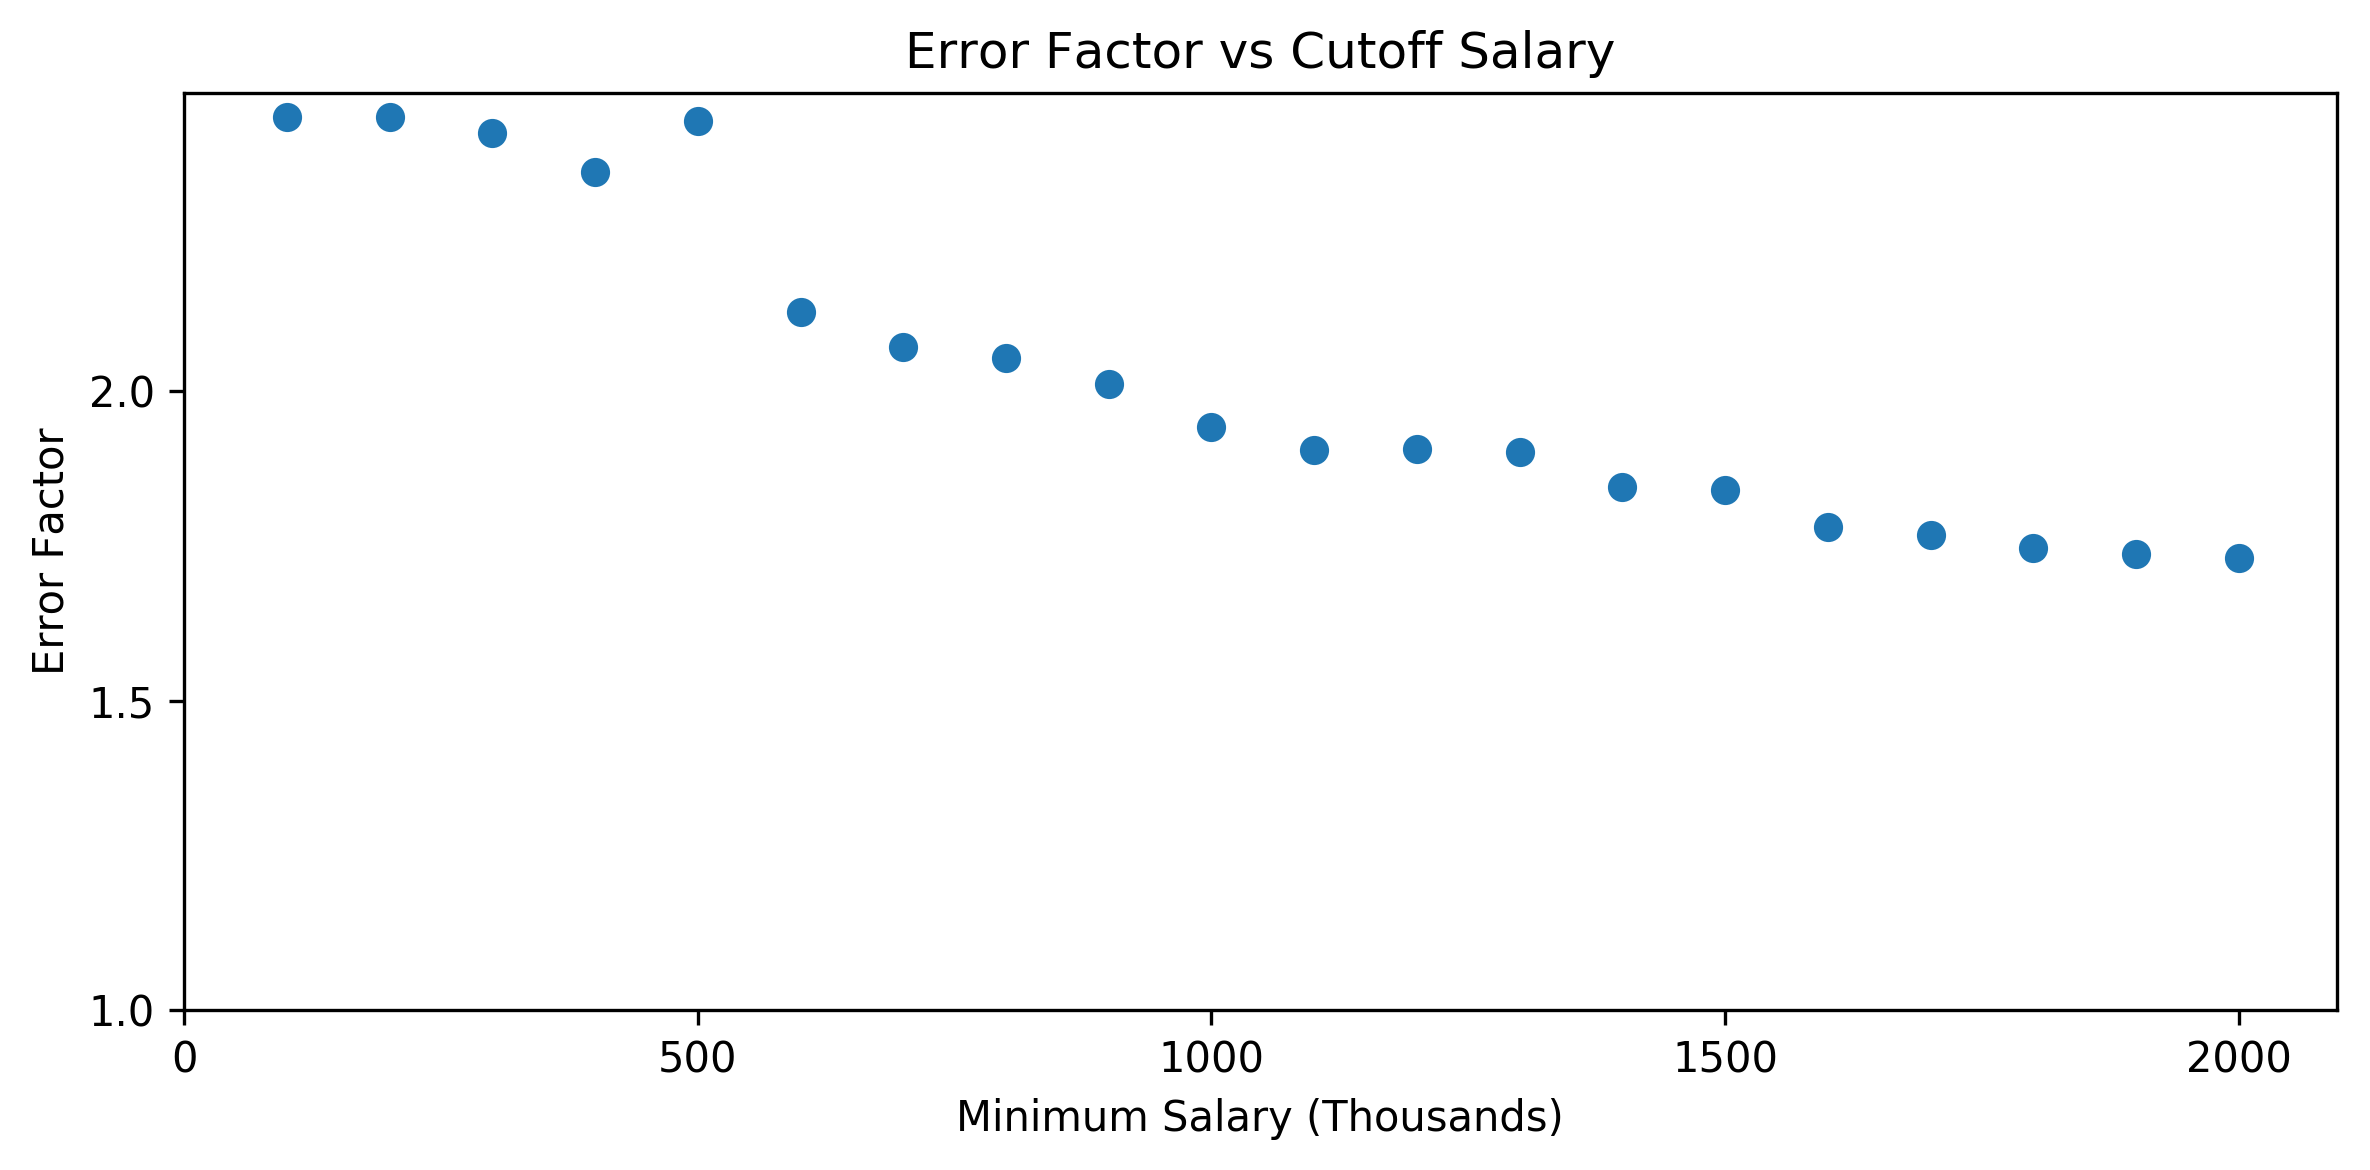

In [151]:
fig,ax = plt.subplots(figsize=(8,4))

ax.scatter([i/1000 for i in cut],err)
ax.set_title("Error Factor vs Cutoff Salary")
ax.set_ylabel("Error Factor")
ax.set_xlabel("Minimum Salary (Thousands)")
ax.set_yticks([1,1.5,2]);
ax.set_xticks([0,500,1000,1500,2000]);
plt.tight_layout()
#plt.savefig('cutofferr.png')

In [136]:
train_X, train_y, test_X, test_y = load_and_split_data(600000)
results = train_EN_model(train_X,train_y,test_X)
error = MSE(test_y,results['y'])

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
...................................................................................................................

ratio(9.000000e-01) -- n: 44 -- alpha: 0.000550 -- mse: 0.089002 -- time: 0.24 sec


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
................................................................................................................

ratio(9.200000e-01) -- n: 44 -- alpha: 0.000538 -- mse: 0.088990 -- time: 0.24 sec


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
........................................................................................................

ratio(9.500000e-01) -- n: 44 -- alpha: 0.000521 -- mse: 0.088975 -- time: 0.23 sec


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
..................................................................................................................

ratio(9.700000e-01) -- n: 44 -- alpha: 0.000510 -- mse: 0.088966 -- time: 0.34 sec


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
.................................................................................................................

ratio(9.900000e-01) -- n: 44 -- alpha: 0.000500 -- mse: 0.088958 -- time: 0.25 sec
Best l1_ratio and alpha: 0.990000, 0.000500


In [116]:
a = test_y.apply(lambda x: 10**x)
b = pd.DataFrame(results['y']).apply(lambda x: 10**x)

In [118]:
MSE(a,b)**.5

8488530.503532259

In [120]:
10**np.mean(test_y)

5581972.151201913

In [123]:
10**(MSE(test_y,results['y'])**.5)

1.5146720269766363

In [125]:
(10**np.mean(test_y))*(10**(MSE(test_y,results['y'])**.5))

8454857.072788136

In [142]:
results['coef']

array([ 1.35684538e+00, -0.00000000e+00,  0.00000000e+00,  5.14655213e-02,
       -0.00000000e+00, -4.34495743e-02, -0.00000000e+00, -1.04023748e-01,
        8.94476060e-02, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.17308499e-01, -9.08638565e-03, -9.58814257e-02,  1.18751163e-03,
       -3.20421875e-03, -4.33620299e-02,  1.31848124e-02,  0.00000000e+00,
        7.62317049e-02,  2.36664347e-02, -0.00000000e+00, -6.90560853e-02,
       -5.33377037e-02, -0.00000000e+00,  5.10164762e-02,  0.00000000e+00,
       -1.20531540e-01,  5.28222170e-02,  8.45742837e-02, -4.21871998e-02,
       -6.84498133e-02, -2.91755189e-02,  9.55316057e-02,  1.44062467e-01,
       -7.34204403e-02,  3.80612854e-02, -0.00000000e+00, -1.24926437e-01,
        0.00000000e+00,  3.02143160e-03,  5.54480690e-02, -1.04231413e-01,
       -0.00000000e+00, -8.78436291e-02, -1.34985362e-02,  0.00000000e+00,
        0.00000000e+00, -

In [143]:
train_X.columns

Index(['pa', 'rbat', 'rbaser', 'rdp', 'rfield', 'rpos', 'raa', 'waa', 'rrep',
       'rar', 'war', 'waawl%', '162wl%', 'owar', 'dwar', 'orar', 'year',
       'acquired_dr', 'acquired_fa', 'bat_hand_lhb', 'bat_hand_swh', 'tm_ARI',
       'tm_ATL', 'tm_BAL', 'tm_BOS', 'tm_CHC', 'tm_CHW', 'tm_CIN', 'tm_CLE',
       'tm_COL', 'tm_DET', 'tm_HOU', 'tm_KCR', 'tm_LAA', 'tm_LAD', 'tm_MIA',
       'tm_MIL', 'tm_MIN', 'tm_NYM', 'tm_NYY', 'tm_OAK', 'tm_PHI', 'tm_PIT',
       'tm_SDP', 'tm_SEA', 'tm_SFG', 'tm_STL', 'tm_TBR', 'tm_TEX', 'tm_TOR',
       'tm_WSN', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb',
       'so', 'ibb', 'hbp', 'sh', 'sf', 'gidp', 'years_in_mlb', 'g'],
      dtype='object')

In [145]:
pd.DataFrame(train_X.columns,results['coef']).reset_index()

,index,0
0,1.356845,pa
1,-0.000000,rbat
2,0.000000,rbaser
3,0.051466,rdp
4,-0.000000,rfield
5,-0.043450,rpos
6,-0.000000,raa
7,-0.104024,waa
8,0.089448,rrep
9,-0.000000,rar


In [139]:
10**(error**.5)

2.1285048645864593

In [173]:
from sklearn.feature_selection import RFE
train_X, train_y, test_X, test_y = load_and_split_data(i)
est = LinearRegression()

sel = RFE(est)
sel = sel.fit(train_X,train_y)

preds = sel.predict(test_X)

error = MSE(test_y,preds)**.5
print(error)
print(10**error)

0.5784257776394642
3.7881378768918075


In [161]:
(10**np.mean(test_y))*(10**(MSE(test_y,preds)**.5))

13661955.80893889

In [162]:
train_X.columns

Index(['pa', 'rbat', 'rbaser', 'rdp', 'rfield', 'rpos', 'raa', 'waa', 'rrep',
       'rar', 'war', 'waawl%', '162wl%', 'owar', 'dwar', 'orar', 'year',
       'acquired_dr', 'acquired_fa', 'bat_hand_lhb', 'bat_hand_swh', 'tm_ARI',
       'tm_ATL', 'tm_BAL', 'tm_BOS', 'tm_CHC', 'tm_CHW', 'tm_CIN', 'tm_CLE',
       'tm_COL', 'tm_DET', 'tm_HOU', 'tm_KCR', 'tm_LAA', 'tm_LAD', 'tm_MIA',
       'tm_MIL', 'tm_MIN', 'tm_NYM', 'tm_NYY', 'tm_OAK', 'tm_PHI', 'tm_PIT',
       'tm_SDP', 'tm_SEA', 'tm_SFG', 'tm_STL', 'tm_TBR', 'tm_TEX', 'tm_TOR',
       'tm_WSN', 'ab', 'r', 'h', '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb',
       'so', 'ibb', 'hbp', 'sh', 'sf', 'gidp', 'years_in_mlb', 'g'],
      dtype='object')

In [170]:
print ('coefficients',sel.estimator_.coef_)

coefficients [ 7.37655574 -2.29619992 -0.20992986  2.1729475   0.47517645 -0.09330379
 -2.20516883 -0.29700059 -1.44883673  4.75188945  0.4181296  -0.14906247
 -3.77028316 -3.84697889  4.62171711  0.1361316  -0.16640724 -0.13602596
  0.21752345 -0.1576653  -0.14453414 -0.1410821  -5.65882207 -0.29591504
 -0.22879338 -0.23711018  0.19727794 -2.22169308  1.00794965 -0.40731282
 -0.60369004 -0.14475715  0.26826555 -1.27787616]


In [171]:
print(sel.support_)

[ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False  True False False  True
 False False False  True  True False False  True False False False  True
 False False False  True False  True  True  True False  True False False
  True False  True  True  True  True  True False  True]


In [174]:
train_X.columns[sel.support_]

Index(['pa', 'rbat', 'rfield', 'rpos', 'raa', 'waa', 'rrep', 'rar', 'war',
       'owar', 'dwar', 'orar', 'year', 'acquired_dr', 'tm_CLE', 'tm_KCR',
       'tm_MIA', 'tm_NYY', 'tm_OAK', 'tm_SDP', 'tm_TBR', 'ab', 'h', '2b', '3b',
       'rbi', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf', 'gidp', 'g'],
      dtype='object')

In [177]:
def cutoffs_RFE():
    test_cutoffs = [(i+1)*100000 for i in range(20)]
    error_list = []
    for i in test_cutoffs:
        train_X, train_y, test_X, test_y = load_and_split_data(i)
        est = LinearRegression()

        sel = RFE(est)
        sel = sel.fit(train_X,train_y)
        
        error = MSE(test_y,sel.predict(test_X))**.5
        error_list.append(10**error)

    return test_cutoffs,error_list  

In [178]:
cut,err = cutoffs_RFE()

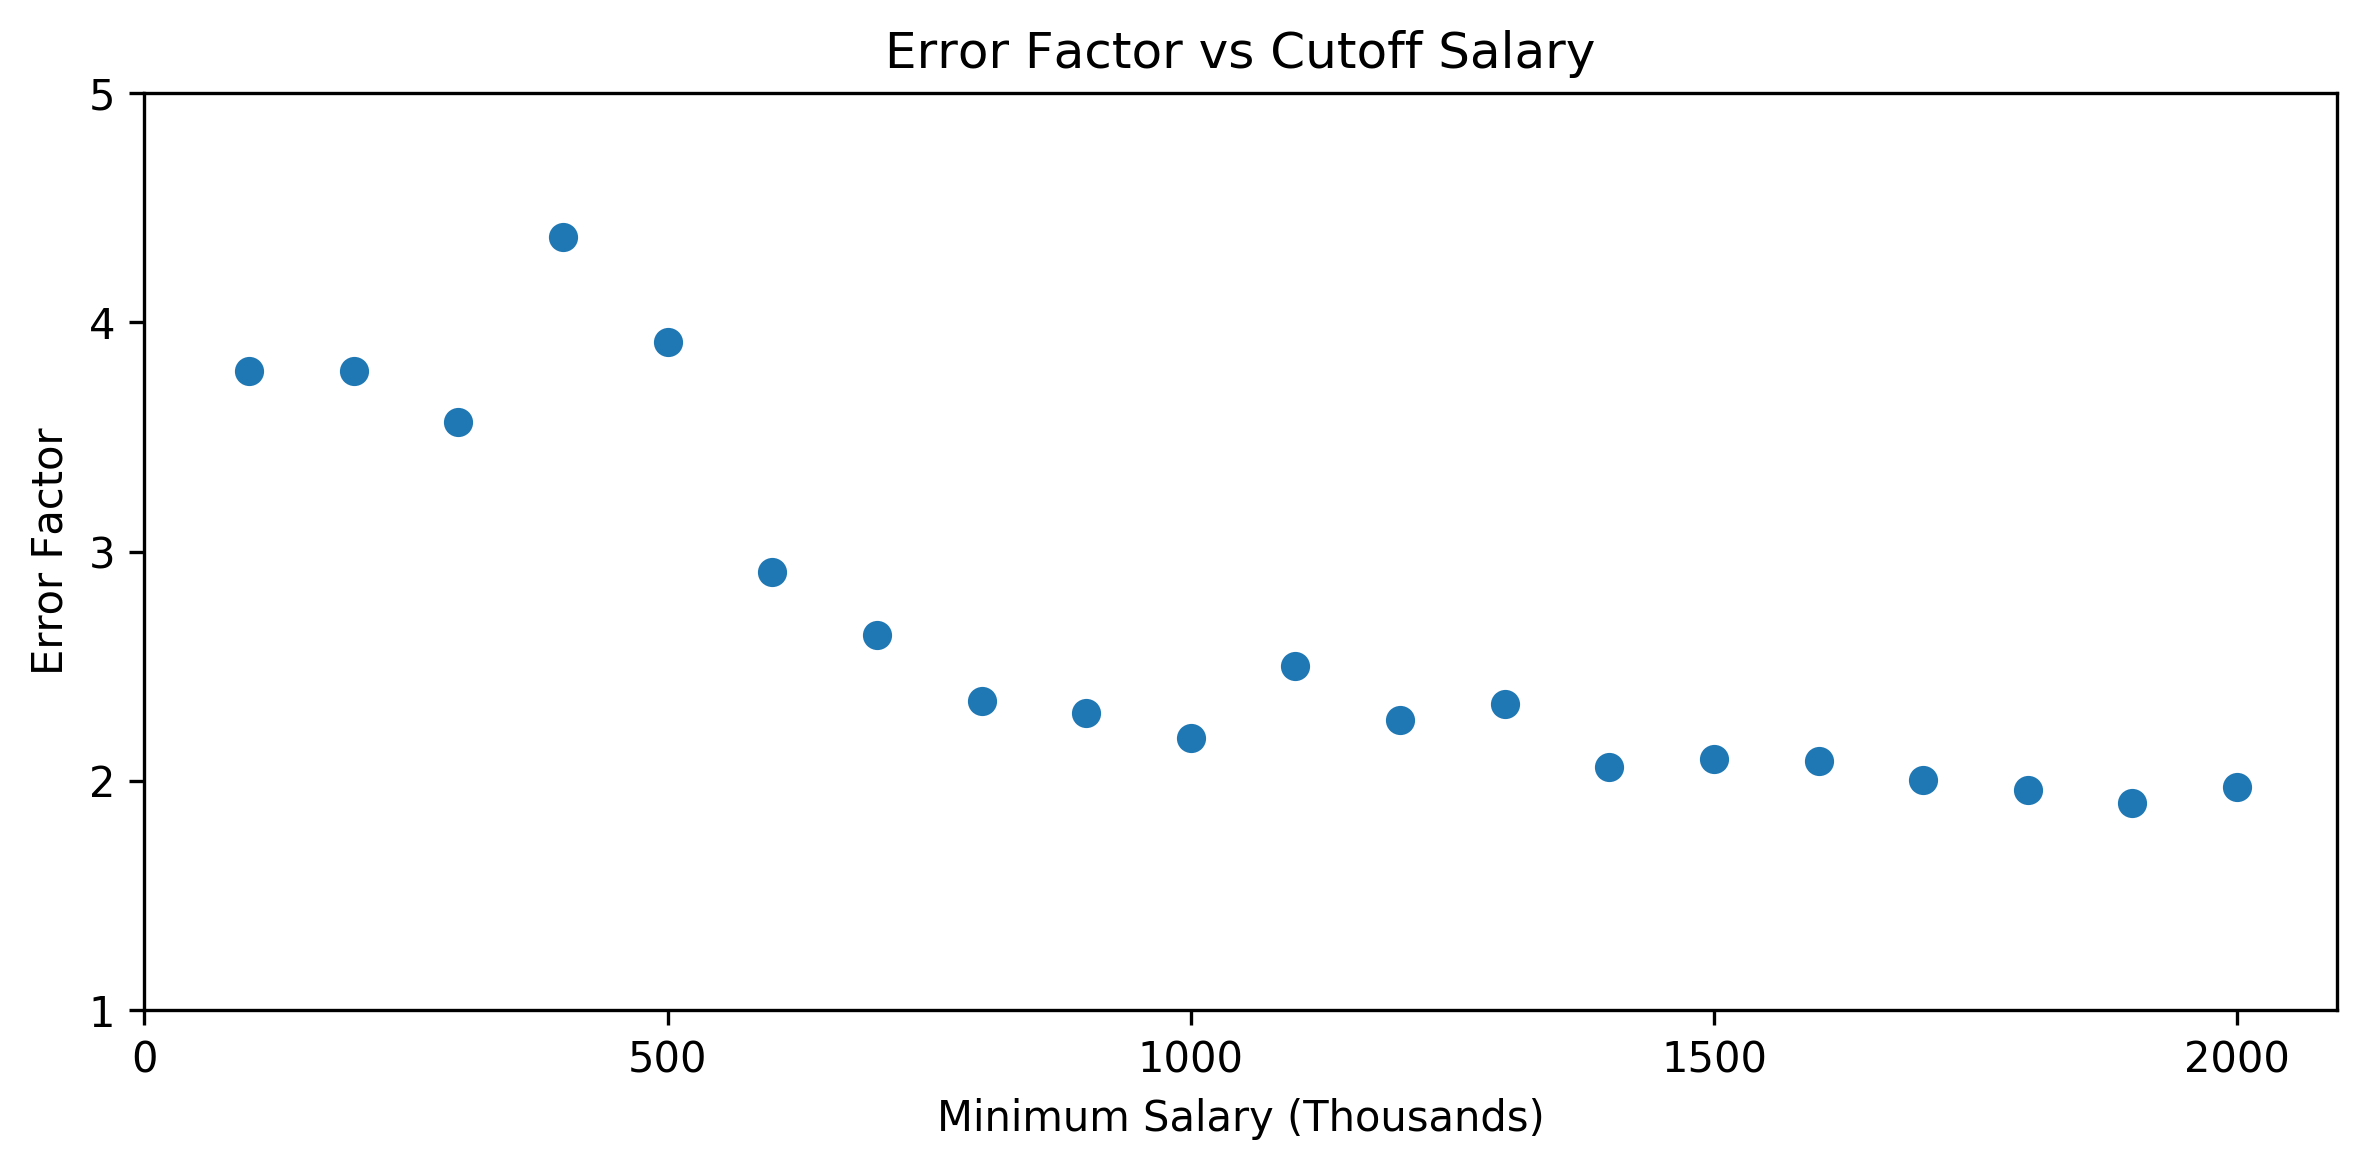

In [180]:
fig,ax = plt.subplots(figsize=(8,4))

ax.scatter([i/1000 for i in cut],err)
ax.set_title("Error Factor vs Cutoff Salary")
ax.set_ylabel("Error Factor")
ax.set_xlabel("Minimum Salary (Thousands)")
ax.set_yticks([1,2,3,4,5]);
ax.set_xticks([0,500,1000,1500,2000]);
plt.tight_layout()
#plt.savefig('cutofferr.png')